# The group LASSO for least squares

This notebook provides some ways to solve the group LASSO problem
$$
\frac{1}{2} \|Y-X\beta\|^2_2 + \lambda \sum_i \|\beta[g_i]\|_2
$$
where $g_i$ are pairwise distinct subsets of $\{1, \dots, p\}$.


In [1]:
# third party imports
import numpy as np
import pylab
from scipy import sparse
%pylab inline
# the regreg import
import regreg.api as rr

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy



We will use the CGH data from the R package cghFLasso. You will have to have installed the package 'cghFLasso' in R, as well as installed rpy2.



In [2]:
import rpy2.robjects as ri
ri.r(''' 
library(gglasso)
data(bardet)
group1 = rep(1:20,each=5)
Y = bardet$y
X = matrix(rnorm(120*100), 120, 100) # bardet$x
gg1 = gglasso(x=X,y=Y,group=group1,loss="ls")
B = gg1$beta
L = gg1$lambda
DF = gg1$df
''')
B = np.array(ri.r("B"))
DF = np.array(ri.r("DF"))
L = np.array(ri.r("L"))
Y = np.array(ri.r('Y')); Y -= Y.mean()
X = np.array(ri.r('X')); X -= X.mean(0)[np.newaxis,:]
n, p = X.shape
loss = rr.squared_error(X, Y, coef=1./n)
print X.shape, Y.shape

(120, 100) (120,)


In [4]:
groups = []
for i in range(20):
    groups.extend([i]*5)
penalty = rr.group_lasso(groups, lagrange=L.max())

It is useful to have a global Lipschitz constant to start the algorithm so the backtracking step
 does not have a long search. For least squares we can take

$$
\|\nabla {\mathcal L}\|_{\mathrm{Lip}} = \frac{1}{n}\|X\|_{\mathrm{op}}^2
$$

In [5]:
lipschitz = rr.power_L(X)**2 / n

We are all set to specify the problem and solve it. This is a "simple" problem in that its proximal
 operator is separable. It can be specified with the "simple_problem" class.

In [6]:
print loss.shape, penalty.shape
problem = rr.simple_problem(loss, penalty)
coefs = problem.solve(tol=1.e-12, min_its=400)
print coefs[groups[0]]


(100,) (100,)
0.0


The problem could also be solved by a straightforward generalized gradient algorithm that does no backtracking. This generally does not work as well because the global Lipschitz constant is much larger than it has to be. To be fair 
to FISTA, we will set the penalty.coefs to 0, as these are currently saved at the current solution. The gengrad class uses a stopping rule based on change in the objective value unless the optional argument "coef_stop" is True. 


## Constructing a path of solutions (not using strong rules)

In [8]:
score0 = loss.smooth_objective(np.zeros(100), mode='grad')
dual_penalty = rr.group_lasso_dual(groups, lagrange=1.)
lagrange_max = dual_penalty.seminorm(score0)
lagrange_seq = lagrange_max * np.exp(np.linspace(np.log(0.001), 0, 100))[::-1][DF < 110]

In [12]:
%%timeit
problem = rr.simple_problem(loss, penalty)
penalty.lagrange = lagrange_max
solns = [problem.solve(tol=1.e-7, min_its=20)]
final_step = problem.final_step
for iterct, lagrange in enumerate(lagrange_seq[1:]):
    penalty.lagrange = lagrange
    solns.append(problem.solve(start_step=final_step, tol=1.e-10).copy())
    final_step = problem.final_step

1 loops, best of 3: 1.56 s per loop


In [13]:
%%timeit
ri.r('gg1 = gglasso(x=X,y=Y,group=group1,loss="ls")')

10 loops, best of 3: 79.9 ms per loop


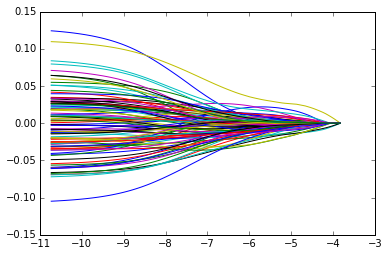

In [14]:
problem = rr.simple_problem(loss, penalty)
penalty.lagrange = lagrange_max
solns = [problem.solve(tol=1.e-7, min_its=20)]
final_step = problem.final_step
for iterct, lagrange in enumerate(lagrange_seq[1:]):
    penalty.lagrange = lagrange
    solns.append(problem.solve(start_step=final_step, tol=1.e-10).copy())
    final_step = problem.final_step
solns = np.array(solns)
a = [plt.plot(np.log(lagrange_seq), solns[:,i]) for i in range(100)]
#plt.gca().set_ylim([-0.5,0.5])

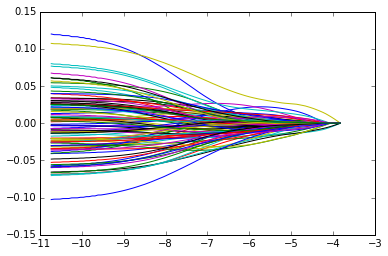

In [15]:
b = [pylab.plot(np.log(lagrange_seq), B[i][DF < 110]) for i in range(100)];
#plt.gca().set_ylim([-0.5,0.5])

In [16]:
B.shape

(100, 100)

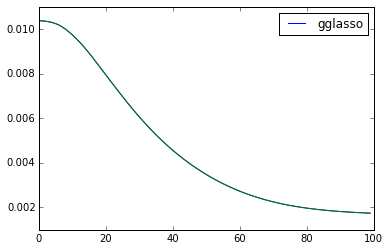

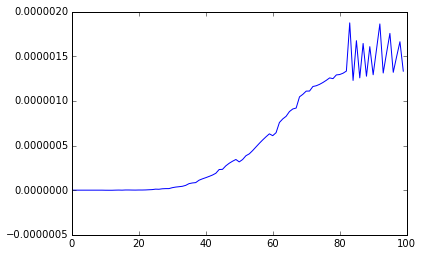

In [17]:
obj_vals = []
for i, lagrange in enumerate(lagrange_seq):
    penalty.lagrange = lagrange
    val1 = problem.objective(B[:,i])
    val2 = problem.objective(solns[i])
    obj_vals.append((val1, val2, val1 - val2))
obj_vals = np.array(obj_vals)
plt.plot(obj_vals[:,0], label='gglasso')
plt.plot(obj_vals[:,1])
plt.legend()
plt.figure()
plt.plot(obj_vals[:,2])

In [18]:
LS = np.linalg.pinv(X).dot(Y)
LS.min(), LS.max()

(-0.10760928139610371, 0.12857278198574495)

In [19]:
penalty.lagrange=lagrange_seq[-1]
B0 = problem.solve(min_its=10000)
B0.min(), B0.max()

(-0.10484033728926208, 0.124296625888018)

In [20]:
np.linalg.norm(B0 - solns[-1]), np.linalg.norm(B0 - B[:,-1])

(0.00044949688003706798, 0.015707671750503659)

In [21]:
problem.objective(B0), problem.objective(solns[-1]), problem.objective(B[:,-1])

(0.0017459857935127805, 0.0017459862652682337, 0.0017473189984663769)